<a href="https://colab.research.google.com/github/dheerajreddy3108/Advanced-Driver-Assistance-System/blob/main/Sentiment_Analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/')
os.getcwd()

'/content/gdrive/My Drive'

In [3]:
#importing  Basic Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
#importing NLTK related Libraries
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from gensim.models import Word2Vec


#importing Tensorflow Libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
#changing the settings to see complete text in the output box of each cell

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [6]:
#setting the path for the training and testing data

path = '/content/gdrive/My Drive/sentiment_data'
files = os.listdir(path)
print(files)

['testdata.csv', 'training.csv', 'temp.gsheet', 'temp.csv', 'word2vec.model', 'variables', 'assets', 'keras_metadata.pb', 'saved_model.pb']


In [92]:
#adding a header to the csv file 

csv_cols = ['target_label', 'ids','date','flag','user','tweet']
df_train = pd.read_csv(os.path.join(path, 'training.csv'),encoding='ISO-8859-1', names = csv_cols)

df_train.dropna(inplace=True)
print(df_train.shape)

(1600000, 6)


In [93]:
test_label_dict = {0 : 'Negative', 2 : 'Neutral', 4 : 'Positive'}
def test_label_decode(label):
  return test_label_dict[int(label)]



In [94]:
df_train.target_label = df_train.target_label.apply(lambda x : test_label_decode(x))

In [95]:
#visualizing first first rows of training csv file
df_train.head(5)

,target_label,ids,date,flag,user,tweet
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [96]:
#finding the number of categories in the data

unique_labels = df_train['target_label'].unique()
#converting to a list
unique_labels_list = unique_labels.tolist()
print(unique_labels_list)

['Negative', 'Positive']


In [97]:
#finding number of data samples for each label
print(df_train['target_label'].value_counts())

Negative    800000
Positive    800000
Name: target_label, dtype: int64


In [98]:
#reading test csv file and visualizing first 5 rows 

df_test = pd.read_csv(os.path.join(path, 'testdata.csv'),encoding='ISO-8859-1', names = csv_cols)
df_test.target_label = df_test.target_label.apply(lambda x : test_label_decode(x))
df_test.head(5)

,target_label,ids,date,flag,user,tweet
0,Positive,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,Positive,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,Positive,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,Positive,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,Positive,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


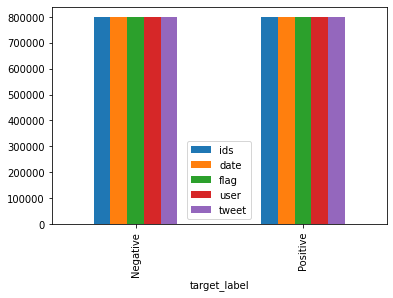

In [14]:
#plot to see the number of tweets per label

df_train.groupby('target_label').count().plot(kind='bar')


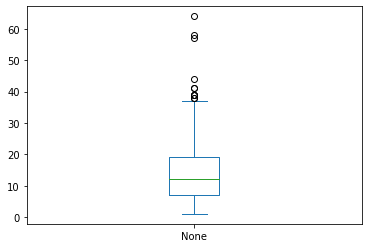

In [15]:
#plot to find the distribution of tweet length

tweet_length = pd.Series([len(tweet.split()) for tweet in df_train['tweet']])
tweet_length.plot(kind = 'box')

In [16]:
#Data Visualization

def data_visualization(target_label,color):
  fig = plt.figure(figsize=(14,7))
  df_train['length'] = df_train.tweet.str.split().apply(len)
  ax1 = fig.add_subplot(122)
  sns.histplot(df_train[df_train['target_label']==target_label]['length'], ax=ax1,color=color)
  describe = df_train.length[df_train.target_label==target_label].describe().to_frame().round(2)

  ax2 = fig.add_subplot(121)
  ax2.axis('off')
  font_size = 14
  bbox = [0, 0, 1, 1]
  table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
  table.set_fontsize(font_size)
  fig.suptitle('Distribution of text length for sentiment tweets.', fontsize=16)

  plt.show()



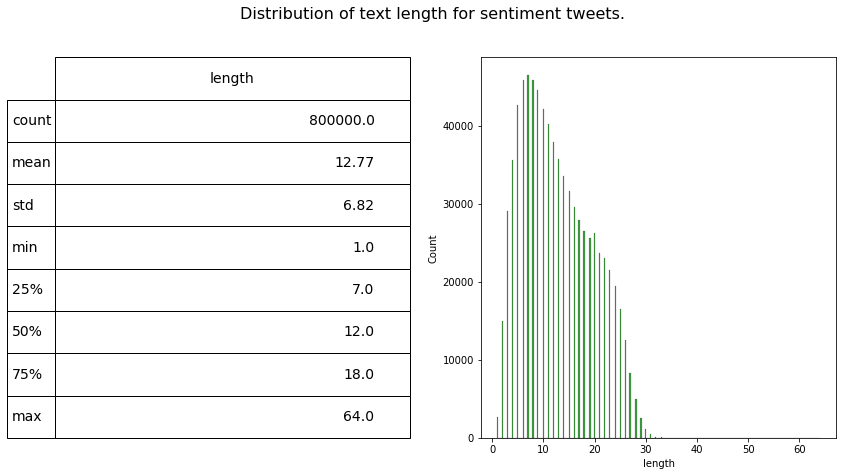

In [16]:
#Visualization with label 4
pos_viz = data_visualization(target_label='Positive',color = 'green')

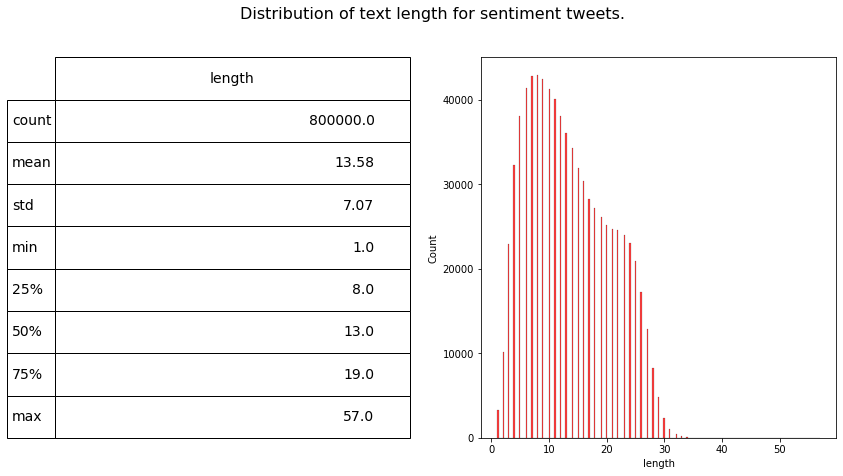

In [17]:
#visualization with label 0
pos_viz = data_visualization(target_label='Negative',color = 'red')

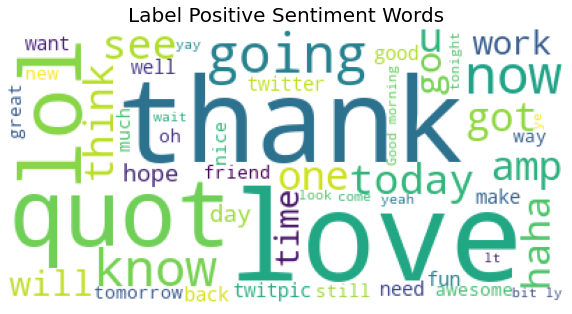

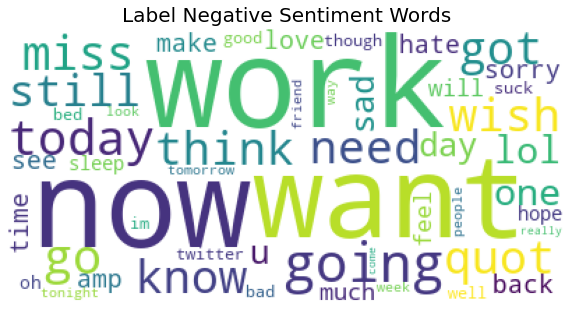

In [27]:

def wordcount_gen(df, target_label):

    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df_train[df_train.target_label==target_label]['tweet']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('Label {} Sentiment Words'.format(target_label), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df_train, 'Positive')
     
# Negative tweet words
wordcount_gen(df_train, 'Negative')
     
     

In [99]:
#removes hyperlink

def remove_links(text):
  text = str(text).lower()
  url_chars = 'https?:\S+|http?:\S+'
  text = re.sub(url_chars, ' ', text).strip()
  return text
  
#removes special charecters 
def remove_spcl_chars(text):
  text = str(text).lower()
  spcl_chars = '[^A-Za-z0-9]+'
  text = re.sub(spcl_chars,' ', text).strip()
  return text


In [76]:
#installing contractions library 

!pip install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
#applying expand contractions

df_train.tweet = df_train.tweet.apply(lambda x : contractions.fix(x))

In [101]:
#can't is changed to cannot after expanding contractions

print(df_train.iloc[1].values)


['Negative' 1467810672 'Mon Apr 06 22:19:49 PDT 2009' 'NO_QUERY'
 'scotthamilton'
 'is upset that he cannot update his Facebook by texting it... and might cry as a result  School today also. Blah!']


In [102]:
#applying function 'remove_links' and 'remove_spcl_chars'

df_train.tweet = df_train.tweet.apply(lambda x: remove_links(x))
df_train.tweet = df_train.tweet.apply(lambda x: remove_spcl_chars(x))

In [103]:
print(df_train.iloc[1].values)


['Negative' 1467810672 'Mon Apr 06 22:19:49 PDT 2009' 'NO_QUERY'
 'scotthamilton'
 'is upset that he cannot update his facebook by texting it and might cry as a result school today also blah']


In [104]:
#removing stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
#remove stopwords using nltk stopwords

def remove_stopwords(text):
  tokens = []
  text = str(text).lower().strip()
  for token in text.split():
    if token not in stop_words:
      tokens.append(token)

  return ' '.join(tokens)



In [106]:
#applying function to the dataset 
df_train.tweet = df_train.tweet.apply(lambda x: remove_stopwords(x))


In [107]:
print(df_train.iloc[1].values)

['Negative' 1467810672 'Mon Apr 06 22:19:49 PDT 2009' 'NO_QUERY'
 'scotthamilton'
 'upset cannot update facebook texting might cry result school today also blah']


In [108]:
#split data
train_data, valid_data = train_test_split(df_train, test_size = 0.2, random_state = 0)

#printing statistics of train and valid data
print('Train Data Shape : ',train_data.shape)
print('Validation Data Shape : ',valid_data.shape)


Train Data Shape :  (1280000, 6)
Validation Data Shape :  (320000, 6)


In [109]:
df_train.head(5)

,target_label,ids,date,flag,user,tweet
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,switchfoot awww bummer shoulda got david carr third day
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cannot update facebook texting might cry result school today also blah
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save 50 rest go bounds
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass behaving mad cannot see


In [110]:
print(df_train.iloc[1])

target_label                                                                        Negative
ids                                                                               1467810672
date                                                            Mon Apr 06 22:19:49 PDT 2009
flag                                                                                NO_QUERY
user                                                                           scotthamilton
tweet           upset cannot update facebook texting might cry result school today also blah
Name: 1, dtype: object


In [111]:
documents = []
for t in train_data.tweet:
  documents.append(t.split())


In [112]:
print(documents[1])

['wore', 'better', 'cosgrovemirana', 'mileycyrus']


In [113]:
#word2vec for word embedding 

w2v = Word2Vec(size =100, window = 7,min_count = 10, workers = 8)

In [114]:
w2v.build_vocab(documents)


In [115]:
words = w2v.wv.vocab.keys()
vocab_size = len(words)
print(vocab_size)

36790


In [116]:
w2v.train(documents, total_examples = len(documents), epochs = 16)

(132964212, 155688528)

In [117]:
#saving word2vec weights
w2v.save('word2vec.model')
#most similar words for word 
w2v.most_similar('fruit')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


[('bananas', 0.7880200147628784),
 ('blueberries', 0.7552123069763184),
 ('oatmeal', 0.7538431882858276),
 ('strawberries', 0.7538381814956665),
 ('flakes', 0.7505530118942261),
 ('spinach', 0.7491496801376343),
 ('cheddar', 0.7465632557868958),
 ('flavour', 0.7441439628601074),
 ('avocado', 0.7441414594650269),
 ('berries', 0.743689775466919)]

In [118]:
#tokenization

tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(train_data.tweet)
vocab_size = len(tokenizer.word_index) + 1


In [119]:
#padding the tweets to have same length for all

max_seq_len = 80
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = max_seq_len)
x_valid = pad_sequences(tokenizer.texts_to_sequences(valid_data.tweet), maxlen = max_seq_len)


In [120]:
train_labels = df_train.target_label.unique().tolist()
train_labels.append('Neutral')


encoder = LabelEncoder()
encoder.fit(train_data.target_label.tolist())

y_train = encoder.transform(train_data.target_label.tolist())
y_valid = encoder.transform(valid_data.target_label.tolist())


In [ ]:
print(vocab_size)

In [ ]:
print(y_valid)

In [ ]:
#defining layers and model 

def embedding_layer(vocab_size, w2v_size, max_seq_len = max_seq_len):
  embedding_matrix = np.zeros((vocab_size, w2v_size))
  for i, word in tokenizer.word_index.items():
    if word in w2v.wv:
      embedding_matrix[i] = w2v.wv[word]

  embedding_layer = Embedding(vocab_size, w2v_size, weights = [embedding_matrix], input_length = max_seq_len)

  return embedding_layer

#Using Adam as optimizer 
optimizer = tf.keras.optimizers.Adam(1e-4)

def nlp_model(optimizer = optimizer):
  model = Sequential()
  model.add(embedding_layer(vocab_size =vocab_size, w2v_size = 100))
  #model.add(Dropout(0.5))
  model.add(LSTM(64, dropout = 0.3, recurrent_dropout = 0.3))
  #model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

model = nlp_model()
model.summary()

#defining training params
batch_size = 1024
epochs = 16
validation_data = (x_valid, y_valid)

def model_training(x_train, y_train,path = path, batch_size= batch_size, epochs = epochs , validation_data= validation_data):
  es = EarlyStopping(monitor = 'val_loss',patience = 5,mode = 'min', restore_best_weights = True)
  mc = ModelCheckpoint(filepath = path, monitor= 'val_loss', save_best_only=True, mode = 'min' )
  hist = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = validation_data, callbacks = [es, mc] )
  return hist


hist = model_training(x_train = x_train, y_train = y_train)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 100)           51663200  
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,705,505
Trainable params: 51,705,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
1250/1250 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.7333

1250/1250 [==============================] - 264s 209ms/step - loss: 0.5464 - accuracy: 0.7333 - val_loss: 0.4987 - val_accuracy: 0.7584
Epoch 2/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.7581

1250/1250 [==============================] - 263s 210ms/step - loss: 0.4996 - accuracy: 0.7581 - val_loss: 0.4951 - val_accuracy: 0.7591
Epoch 3/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4968 - accuracy: 0.7588

1250/1250 [==============================] - 276s 221ms/step - loss: 0.4968 - accuracy: 0.7588 - val_loss: 0.4921 - val_accuracy: 0.7598
Epoch 4/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.7591

1250/1250 [==============================] - 273s 218ms/step - loss: 0.4940 - accuracy: 0.7591 - val_loss: 0.4897 - val_accuracy: 0.7603
Epoch 5/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7597

1250/1250 [==============================] - 268s 215ms/step - loss: 0.4921 - accuracy: 0.7597 - val_loss: 0.4881 - val_accuracy: 0.7608
Epoch 6/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7602

1250/1250 [==============================] - 274s 219ms/step - loss: 0.4903 - accuracy: 0.7602 - val_loss: 0.4866 - val_accuracy: 0.7613
Epoch 7/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.7608

1250/1250 [==============================] - 272s 218ms/step - loss: 0.4889 - accuracy: 0.7608 - val_loss: 0.4855 - val_accuracy: 0.7622
Epoch 8/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4879 - accuracy: 0.7612

1250/1250 [==============================] - 267s 214ms/step - loss: 0.4879 - accuracy: 0.7612 - val_loss: 0.4847 - val_accuracy: 0.7624
Epoch 9/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7616

1250/1250 [==============================] - 272s 217ms/step - loss: 0.4871 - accuracy: 0.7616 - val_loss: 0.4837 - val_accuracy: 0.7627
Epoch 10/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.7620

1250/1250 [==============================] - 273s 219ms/step - loss: 0.4863 - accuracy: 0.7620 - val_loss: 0.4833 - val_accuracy: 0.7630
Epoch 11/16
1250/1250 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.7628

1250/1250 [==============================] - 272s 218ms/step - loss: 0.4851 - accuracy: 0.7628 - val_loss: 0.4819 - val_accuracy: 0.7638
Epoch 12/16
 857/1250 [===================>..........] - ETA: 1:19 - loss: 0.4847 - accuracy: 0.7631

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
def plot_model_metrics(hist):
  accuracy = hist.history['accuracy']
  val_accuracy =  hist.history['val_accuracy']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'blue', label = 'Training Accuracy')
  plt.plot(epochs, val_accuracy, 'green', label = 'Validation Accuracy')
  plt.title( 'Training and Validation Accuracy Curve')
  plt.legend()

plot_model_metrics(hist = hist)

In [ ]:
#preprocessing x_test
def preprocess_test_data(text):

  text = text.apply(lambda x : remove_links(x))
  text = text.apply(lambda x: remove_spcl_chars(x))
  text = text.apply(lambda x: contractions.fix(x))
  text = text.apply(lambda x: remove_stopwords(x))
  return text

df_test.tweet = preprocess_test_data(df_test.tweet)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.tweet), maxlen = max_seq_len)

In [ ]:
df_test.head(5)

In [ ]:
y_test = encoder.fit_transform(df_test.target_label.tolist())
y_test = np.array(y_test).reshape(-1,1)


In [ ]:
eval = model.evaluate(x_test, y_test, batch_size = 1024)

In [ ]:
y_test = list(df_test.target_label)
scores = model.predict(x_test, verbose=1, batch_size=32)
y_pred = [(score) for score in scores]
y_pred = np.argmax(y_pred, axis=-1)

In [59]:
def evaluate(sample_text, max_seq_len = max_seq_len):
  sample_text = pad_sequences(tokenizer.texts_to_sequences([sample_text]), maxlen = max_seq_len)
  y_pred = model.predict([sample_text])[0]
  if y_pred < 0.4:
    return {'label is ' : 'Negative', 'score ' : float(y_pred)}
  else:
    return {'label is ' : 'Positive', 'score ' : float(y_pred)}
 
   


In [60]:
sample_text0 = 'My bike was put on hold...should have known that.... argh total bummer'

sample_label0 = evaluate(sample_text = sample_text0)
print(sample_label0)

{'label is ': 'Negative', 'score ': 0.006017748732119799}


In [61]:
sample_text1 = 'I Love apple'

sample_label1 = evaluate(sample_text = sample_text1)
print(sample_label1)

{'label is ': 'Positive', 'score ': 0.8026342988014221}


In [62]:
sample_text2 = 'I was so excited to meet Sachin!!!'

sample_label2 = evaluate(sample_text = sample_text2)
print(sample_label2)

{'label is ': 'Positive', 'score ': 0.9495143294334412}
